In [1]:
#!g1.1
import os
import copy
import random
import shutil
import torch
import torchvision
import IPython

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A

from albumentations.pytorch import ToTensorV2
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
from tqdm.notebook import trange
from math import ceil
from glob import glob

os.chdir("./MILTestTasks-task-human_segmentation")
from lib import *

%matplotlib inline


In [2]:
#!g1.1
IMAGE_TRAIN_PATH = "data/train"
IMAGE_VAL_PATH = "data/valid"
IMAGE_TEST_PATH = "data/test"

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

---

### Анализ данных

Визуализируем фотографии

In [3]:
#!g1.1
def visualize_image(path="./data/train", samples=10):
    """The function gets a derictory and outputs images"""
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        images = os.listdir(path)
        ind = np.random.choice(images).split(".")[0]
        img = np.array(Image.open(f"{path}/{ind}.jpg"))
        mask = np.array(Image.open(f"{path}_mask/{ind}.png"))

        ax[i, 0].imshow(img)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()
    

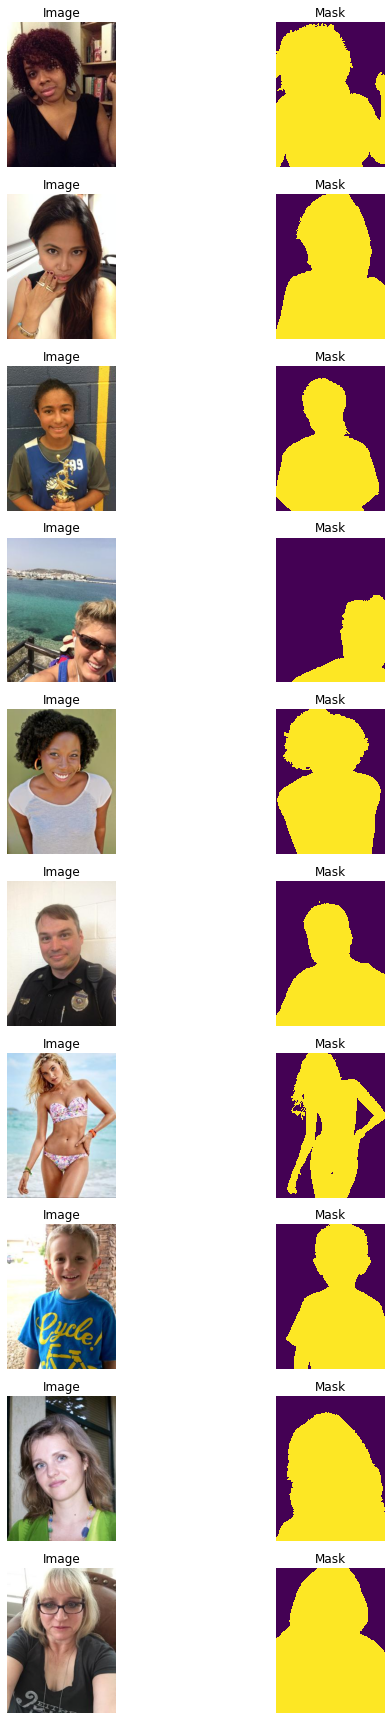

In [4]:
#!g1.1
visualize_image()


Основные выводы:
1) В основном фотографии лиц, но также встречаются фотографии в полный рост \
2) Присутствует люди разного пола, возраста,  национальности \
3) На фотографии присутствует только один человек \
4) Встречаются изображения в серых тонах или с другими фильтрами \
5) Разный фон


Теперь посмотрим на количество фотографий:

In [5]:
#!g1.1
def cnt_image(path="./data/train"):
    """The function gets the derictory and outputs the number of images"""
    images = os.listdir(path)
    return len(images)


print(f'Количество картинок для обучения: {cnt_image("./data/train")}')
print(f'Количество картинок для валидации: {cnt_image("./data/valid")}')
print(f'Количество картинок для теста: {cnt_image("./data/test")}')


Количество картинок для обучения: 1315
Количество картинок для валидации: 145
Количество картинок для теста: 100


Фотографий не так много, что может привести к переобучению. Чтобы как-то решить эту проблему воспользуемся аугментацией изображений.

---

### Аугментация и предобработка 

Для начала подготовим классы для удобной работы с датасетом

In [98]:
#!g1.1
def preprocess_mask(mask):
    """The function processes the picture: pixels take the values 0.0 or 1.0"""
    mask = mask.astype(np.float32)
    mask = mask / 255
    return mask


In [99]:
#!g1.1
# Кастомные датасеты для удобной работы с изображениями
class SegPeopleDataset(torch.utils.data.Dataset):
    """Dataset for storing images and masks"""
    
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.listdir = os.listdir(path)

    def __getitem__(self, idx):
        idx = idx % len(self.listdir)
        idx = int(self.listdir[idx].split('.')[0])
        path = self.path

        img = np.array(Image.open(f"{path}/{idx}.jpg"))
        mask = np.array(Image.open(f"{path}_mask/{idx}.png"))
        mask = preprocess_mask(mask)

        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]

        return img, mask

    def __len__(self):
        return len(self.listdir)


class SegPeopTestleDataset(torch.utils.data.Dataset):
    """Dataset for image storage and image index"""
    
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.listdir = sorted(os.listdir(path))

    def __getitem__(self, idx):
        idx = idx % len(self.listdir)
        idx = int(self.listdir[idx].split('.')[0])
        path = self.path

        img = np.array(Image.open(f"{path}/{idx}.jpg"))

        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed["image"]

        return img, idx

    def __len__(self):
        return len(self.listdir)


Как было замечено ранее, картинок не так много, поэтому воспользуемся аугментацией, предлагаю рассмотреть:
1) Изменение rgb, яроксти, контрастности, оттенки серого, винтаж  -- добавит новые изображения с другим цветом кожи/фоном/одежды; \
2) Blur, Emboss, тени -- добавит шум, сделает сети более устойчивыми; \
3) Горизонтальный поворот, обрезание -- добавит новые изображения. 

Также стоит добавить нормализацию, для более стабильной градиентной оптимизации нейросетей.

Рассмотрим несколько комбинаций методов и в дальнейшем выберем наилучшую.

In [100]:
#!g1.1
train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),

        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.ToGray(p=0.1),

        A.GaussianBlur(p=0.2),
        A.Emboss(p=0.6),

        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

train_transform2 = A.Compose(
    [
        A.HorizontalFlip(p=0.5),

        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.2),

        A.GaussianBlur(p=0.2),
        A.Emboss(p=0.3),

        A.RandomShadow(p=0.3),
        A.RandomToneCurve(p=0.3),

        A.ToSepia(p=0.1),
        A.ToGray(p=0.1),

        A.OneOf([
            A.RandomSizedCrop(min_max_height=(210, 220), height=320, width=240, p=0.5),
            A.PadIfNeeded(min_height=320, min_width=240, p=1)
        ], p=1),

        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

simple_train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),

        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_val_transform = A.Compose(
    [A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)

train_data = SegPeopleDataset(IMAGE_TRAIN_PATH, transform=train_transform)
train2_data = SegPeopleDataset(IMAGE_TRAIN_PATH, transform=train_transform2)
simple_train_data = SegPeopleDataset(IMAGE_TRAIN_PATH, transform=simple_train_transform)
val_data = SegPeopleDataset(IMAGE_VAL_PATH, transform=test_val_transform)
test_data = SegPeopTestleDataset(IMAGE_TEST_PATH, transform=test_val_transform)


In [117]:
#!g1.1
train_dataloader = torch.utils.data.DataLoader(
    train_data, shuffle=True,
    batch_size=16, num_workers=8
)

train2_dataloader = torch.utils.data.DataLoader(
    train2_data, shuffle=True,
    batch_size=16, num_workers=8
)

simple_train_dataloader = torch.utils.data.DataLoader(
    simple_train_data, shuffle=True,
    batch_size=16, num_workers=8
)

val_dataloader = torch.utils.data.DataLoader(
    val_data, shuffle=False,
    batch_size=16, num_workers=8
)


Посмотрим на результат:

In [102]:
#!g1.1
def visualize_augmentations(dataset, idx=500, samples=10):
    """The function visualizes an augmented image"""
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()
    

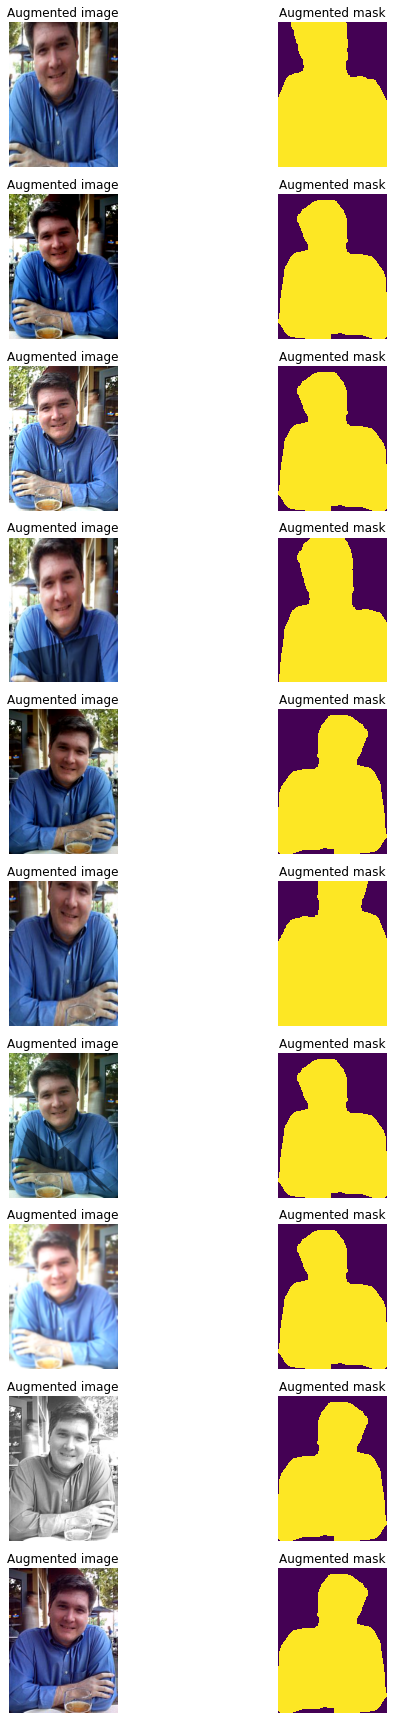

In [103]:
#!g1.1
visualize_augmentations(train2_data, idx=3)

---

### Реализация нейросетей

#### UNet
В качестве первой модели предлагаю рассмотреть одну из сверточных нейросетей в задаче сегментации клеток, которая в дальнейшем набрала популярность -- U-Net. \
Ссылка на статью: https://arxiv.org/pdf/1505.04597.pdf 

Модель делится на две части: 
1) В первой с помощью сверток 3х3 и ReLU мы увеличиваем размерность каналов, а после чего с помощью Max Pool 2x2 понижаем размерность изображений; \
2) С помощью специальных сверток Up-conv мы увеличиваем размерность изображений, постепенно снижая количество каналов и с помощью skip connection копируем слои с первой части и конкатим с слоями второй части. \
Данная модель позволяет прокидывать градиент и тем самым не давать ему затухать на первых слоях, а также добавление skip connection позволяет основному пути сосредоточится на принятии глобальных решений, а добавлением информации с skip connection уточнять информацию.

Замечание, в статье нет пакетной нормализации, добавим её чтобы избавится от смещения градиента.

In [12]:
#!g1.1
class BlockConv(nn.Module):
    """BlockConv consists of the repeated
    application of two 3x3 convolutions (unpadded convolutions), each followed by
    a rectified linear unit (ReLU) and Batch Normalization """

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class DownConv(nn.Module):
    """ DownConv consists of BlockConv and a 2x2 max pooling operation with stride 2 for downsampling."""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_conv = nn.Sequential(
            nn.MaxPool2d(2),
            BlockConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down_conv(x)


class UpConv(nn.Module):
    """UpConv consists of an upsampling of the
    feature map followed by a 2x2 convolution (“up-convolution”) that halves the
    number of feature channels, a concatenation with the correspondingly
    feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU + BatchNorm2d."""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = BlockConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)

        return x


class OutConv(nn.Module):
    """ At the final layer a 1x1 convolution is used to map each 64-
    component feature vector to the desired number of classes. """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [13]:
#!g1.1
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = BlockConv(n_channels, 64)
        self.down1 = DownConv(64, 128)
        self.down2 = DownConv(128, 256)
        self.down3 = DownConv(256, 512)
        self.down4 = DownConv(512, 1024)
        self.up1 = UpConv(1024, 512)
        self.up2 = UpConv(512, 256)
        self.up3 = UpConv(256, 128)
        self.up4 = UpConv(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


Получилась модель как в статье, за исключением того, что я добавил нормализацию и убрал cropping для skip connection слоев  так как размерности совпадают.

#### Global Convolutional Network
В качестве второй модели предлагаю рассмотреть сверточную нейросеть с другим подходом к сверткам — Global Convolutional Network (GCN). \
Ссылка на статью: https://arxiv.org/pdf/1703.02719.pdf

Главные особенности модели: 
1) Нейросеть должна полностью состоять из сверточных слоев без полносвязных слоев или глобальных объединений, за счет этого получается сохранить локальную информацию про изображение; \
2) Использование большого размера ядра, что даст возможность сохранять глобальную информацию про изображение. 

Авторы статьи предлагают разделить одну большую свертку на комбинацию сверток 1 × k + k × 1 и k × 1 + 1 × k, которые в итоге будут давать свертку k × k, но при меньшем количестве параметров. Данная идея представлена в BlockGCN.

После больших сверток идет блок с skip connection, чтобы обработать результат больших сверток. Данная идея представлена в BlockBR.

Далее с помощью Deconv мы объединяем слои с более низким разрешением. Благодаря этому у нас получается распознать детали различного масштаба.

In [14]:
#!g1.1
class BlockGCN(nn.Module):
    """Global Convolutional Network module consists of a combination of 1 = k + k = 1 and k = 1 + 1 = k convolutions, 
    which enables densely connections within a large k×k region in the feature map."""

    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()

        self.conv_left = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(kernel_size // 2, 0)),
            nn.Conv2d(out_channels, out_channels, kernel_size=(1, kernel_size), padding=(0, kernel_size // 2))
        )

        self.conv_right = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(1, kernel_size), padding=(0, kernel_size // 2)),
            nn.Conv2d(out_channels, out_channels, kernel_size=(kernel_size, 1), padding=(kernel_size // 2, 0))
        )

    def forward(self, x):
        x1 = self.conv_left(x)
        x2 = self.conv_right(x)

        x = x1 + x2
        return x


class BlockBR(nn.Module):
    """Boundary Refinement consist of residual structure"""

    def __init__(self, num_channels):
        super().__init__()

        self.convBR = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        identity = x
        x = self.convBR(x)
        x += identity
        return x
    

In [51]:
#!g1.1
class GCN(nn.Module):
    def __init__(self, num_classes=1, kernel_size=15):
        super().__init__()

        resnet = torchvision.models.resnet152(pretrained=True)

        self.resnet_layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.resnet_layer1 = nn.Sequential(resnet.maxpool, resnet.layer1)
        self.resnet_layer2 = resnet.layer2
        self.resnet_layer3 = resnet.layer3
        self.resnet_layer4 = resnet.layer4

        resnet_channels = [256, 512, 1024, 2048]

        self.gcn1 = BlockGCN(resnet_channels[0], num_classes, kernel_size)
        self.br1 = BlockBR(num_classes)

        self.gcn2 = BlockGCN(resnet_channels[1], num_classes, kernel_size)
        self.br2 = BlockBR(num_classes)

        self.gcn3 = BlockGCN(resnet_channels[2], num_classes, kernel_size)
        self.br3 = BlockBR(num_classes)

        self.gcn4 = BlockGCN(resnet_channels[3], num_classes, kernel_size)
        self.br4 = BlockBR(num_classes)

        self.br5 = BlockBR(num_classes)
        self.br6 = BlockBR(num_classes)
        self.br7 = BlockBR(num_classes)
        self.br8 = BlockBR(num_classes)
        self.br9 = BlockBR(num_classes)

        self.final_conv = nn.Conv2d(num_classes, num_classes, kernel_size=1)

    def forward(self, x):
        x0 = self.resnet_layer0(x)

        x1 = self.resnet_layer1(x0)
        x2 = self.resnet_layer2(x1)
        x3 = self.resnet_layer3(x2)
        x4 = self.resnet_layer4(x3)

        x1 = self.gcn1(x1)
        x2 = self.gcn2(x2)
        x3 = self.gcn3(x3)
        x4 = self.gcn4(x4)

        x1 = self.br1(x1)
        x2 = self.br2(x2)
        x3 = self.br3(x3)
        x4 = self.br4(x4)

        size_x = (x.size(2), x.size(3))
        size_x0 = (x0.size(2), x0.size(3))
        size_x1 = (x1.size(2), x1.size(3))
        size_x2 = (x2.size(2), x2.size(3))
        size_x3 = (x3.size(2), x3.size(3))

        x4 = F.interpolate(x4, size=size_x3, mode='bilinear', align_corners=True)

        x3 = self.br5(x3 + x4)
        x3 = F.interpolate(x3, size=size_x2, mode='bilinear', align_corners=True)

        x2 = self.br6(x2 + x3)
        x2 = F.interpolate(x2, size=size_x1, mode='bilinear', align_corners=True)

        x1 = self.br7(x1 + x2)
        x1 = F.interpolate(x1, size=size_x0, mode='bilinear', align_corners=True)

        x1 = self.br8(x1)
        x = F.interpolate(x1, size=size_x, mode='bilinear', align_corners=True)

        x = self.br9(x)
        x = self.final_conv(x)
        return x


#### UNet + GCN

Попробуем объединить две предыдущие модели в одну. 

In [16]:
#!g1.1
class UNet_GCN(nn.Module):
    """A neural network that combines U-Net and GCN"""
    
    def __init__(self, num_classes=1, kernel_size=21):
        super().__init__()
        self.unet = UNet(3, 3)
        self.gcn = GCN(num_classes=num_classes, kernel_size=kernel_size)

    def forward(self, x):
        x = self.unet(x)
        x = self.gcn(x)
        return x
    

#### Pyramid Scene Parsing Network

В качестве поселдней модели предлагаю рассмотреть сверточную нейросеть с интересным подходам к пулингу — Pyramid Scene Parsing Network¶ (PSPN).
Ссылка на статью: https://arxiv.org/pdf/1612.01105.pdf,https://hszhao.github.io/projects/pspnet/

Авторы статьи напоминают про идею глобальных пулингов в классификации изображений, и что они позволяют учесть агрегированную информацию. Но как показала эта статья (https://arxiv.org/pdf/1412.6856.pdf), реальный размер receptive field отличается от теоретического. Кроме того, в случае сегментации не совсем понятно как использовать глобальные пулинги. Авторы статьи предлагают рассмотреть пирамидальную структуру пулингов (pyramid pooling module), которая пытается решить вышеописанные проблемы.

Pyramid pooling module включает в себя четыре блока с разным пулингом. Первый блок из входа с помощью глобального пулинга выдает векторное представление, которое с помощью сверточных слоев преобразуется в одно число. Следующий блок разделяет вход на несколько подобластей в которых уже применяет глобальный пулинг, а дальше сверточные слой. И так далее. В итоге мы получаем блоки на выходе которых слои разной размерности, которые содержат информацию о входных слоях. После мы повышаем размерность до размерности входных слоев и конкатим с ними.

С помощью пиромидального пулинга можно получить глобальную информацию разного масштаба и для разных частей входных слоев.

Для глобального пулинг будем использовать среднее, так как в статье результат при таком пулинге лучше. Кроме того как и в статье, будем использовать слои ResNet101.

In [114]:
#!g1.1
class PyramidPoolingModule(nn.Module):
    """The pyramid pooling module fuses features under four
    different pyramid scales. The coarsest level highlighted in
    red is global pooling to generate a single bin output. The
    following pyramid level separates the feature map into different 
    sub-regions and forms pooled representation for different locations. 
    The output of different levels in the pyramid pooling module contains 
    the feature map with varied sizes. Then we directly upsample 
    the low-dimension feature maps to get the same size
    feature as the original feature map via bilinear interpolation.
    Finally, different levels of features are concatenated as the
    final pyramid pooling global feature."""

    def __init__(self, in_channels, out_channels, pooling_sizes):
        super().__init__()

        self.pyramid_scale1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(pooling_sizes[0]),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.pyramid_scale2 = nn.Sequential(
            nn.AdaptiveAvgPool2d(pooling_sizes[1]),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.pyramid_scale3 = nn.Sequential(
            nn.AdaptiveAvgPool2d(pooling_sizes[2]),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.pyramid_scale4 = nn.Sequential(
            nn.AdaptiveAvgPool2d(pooling_sizes[3]),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        size_image_x = (x.size()[2], x.size()[3])
       
        x1 = F.interpolate(self.pyramid_scale1(x), size_image_x, mode='bilinear', align_corners=True)
        x2 = F.interpolate(self.pyramid_scale2(x), size_image_x, mode='bilinear', align_corners=True)
        x3 = F.interpolate(self.pyramid_scale3(x), size_image_x, mode='bilinear', align_corners=True)
        x4 = F.interpolate(self.pyramid_scale4(x), size_image_x, mode='bilinear', align_corners=True)

        out = torch.cat((x, x1, x2, x3, x4), 1)
        return out


In [119]:
#!g1.1
class PSPNet(nn.Module):
    
    def __init__(self, num_classes, pretrained=True, use_aux=True):
        super().__init__()
        self.use_aux = use_aux
        
        resnet = torchvision.models.resnet101(pretrained=True, replace_stride_with_dilation=[False, True, True])
        
        self.resnet_layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.resnet_layer1 = resnet.layer1
        self.resnet_layer2 = resnet.layer2
        self.resnet_layer3 = resnet.layer3
        self.resnet_layer4 = resnet.layer4

        self.ppm = PyramidPoolingModule(2048, 512, (1, 2, 3, 6))
        
        self.final = nn.Sequential(
            nn.Conv2d(4096, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=.95),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )


    def forward(self, x):
        x_size = (x.size()[2], x.size()[3])
        x = self.resnet_layer0(x)
        x = self.resnet_layer1(x)
        x = self.resnet_layer2(x)
        x = self.resnet_layer3(x)
       
        x = self.resnet_layer4(x)
        x = self.ppm(x)
        x = self.final(x)
        
        return F.interpolate(x, x_size, mode='bilinear', align_corners=True)

!!! На данных модель не прогонял, из-за нехватки производительности и времени, но решил оставить.

В дальнейшем будем рассматривать UNet, GCN, UNet+GCN.

---

### Обучение нейросетей

#### Метрика: Dice coefficient
В качестве лосса воспользуемся Dice coefficient и будем оптимизировать его напрямую.

Dice coefficient показывает близость двух объектов, реализуем формулу для векторов с википедии (https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient). Чтобы привести метрику к лоссу достаточно добавить минус, а для лучшей нормировки будем вычитать из единицы метрику. Тем самым значения будут лежать в диапазоне  от 0 до 1.   

In [17]:
#!g1.1
def DiceMetric(predict, target):
    """Metric considers the similarity of two images"""
    predict = predict.contiguous().view(predict.shape[0], -1)
    target = target.contiguous().view(target.shape[0], -1)

    num = torch.sum(torch.mul(predict, target), dim=1) + 1
    den = torch.sum(predict.pow(2) + target.pow(2), dim=1) + 1

    loss = num / den

    return loss.mean()


class DiceLoss(nn.Module):
    """Loss considers the similarity of two images"""
    
    def __init__(self, smooth=1, p=2, sigmoid=True):
        super().__init__()
        self.smooth = smooth
        self.sigmoid = sigmoid
        self.p = p

    def forward(self, predict, target):
        if self.sigmoid:
            predict = torch.sigmoid(predict)

        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - 2 * num / den

        return loss.mean()
        

#### Реализация цикла обучения
Реализуем три цикла: тренировочный, валидационный, общий.

In [18]:
#!g1.1
def train_loop(model, dataloader, loss_fn, optimizer):
    """Training loop on the entire dataset"""
    out = display(IPython.display.Pretty('Learning...'), display_id=True)
    size = len(dataloader.dataset)
    batches = ceil(size / dataloader.batch_size) - 1

    train_loss = 0

    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)

        # evaluate
        optimizer.zero_grad()
        pred_masks = model(images)
        pred_masks = pred_masks.to(device)
        loss = loss_fn(pred_masks, masks)

        # loss and accuary
        train_loss += loss_fn(pred_masks, masks).item()

        # backpropagation
        loss.backward()
        optimizer.step()

    train_loss /= batches

    return model, optimizer, train_loss


def test_loop(model, dataloader, loss_fn):
    """Testing loop on the entire dataset"""
    size = len(dataloader.dataset)
    test_loss = 0
    batches = ceil(size / dataloader.batch_size)

    with torch.no_grad():
        # evalute and check predictions
        for images, masks in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)
            pred_image = model(images)
            test_loss += loss_fn(pred_image, masks).item()

    test_loss /= batches

    print(f"Validation loss: {test_loss} \n")
    return test_loss


In [19]:
#!g1.1
def learning_loop(model, optimizer, train_loader, val_loader, criterion, name_model, epochs=10):
    """Learning loop includes training the model, calculating the loss on validation and displaying the results in the figure"""
    losses = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs + 1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train_loop(model, train_loader, criterion, optimizer)
        losses['train_loss'].append(loss)

        loss = test_loop(model, val_loader, criterion)
        losses['val_loss'].append(loss)

        clear_output(True)
        plt.figure(figsize=[15, 10])

        plt.suptitle(f'#{epoch}/{epochs}:')
        plt.plot(losses['train_loss'], 'r.-', label='train')
        plt.plot(losses['val_loss'], 'g.-', label='val')
        plt.title(f'losses for {name_model}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

    return model, optimizer, losses


In [20]:
#!g1.1
def create_model_and_optimizer(net, lr=1e-3, beta1=0.9, beta2=0.999, device=device):
    model = net.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr, [beta1, beta2])
    return model, optimizer


#### Обучение
Выше мы рассмотрели две модели, давайте обучим их и сравним результаты на валидации.

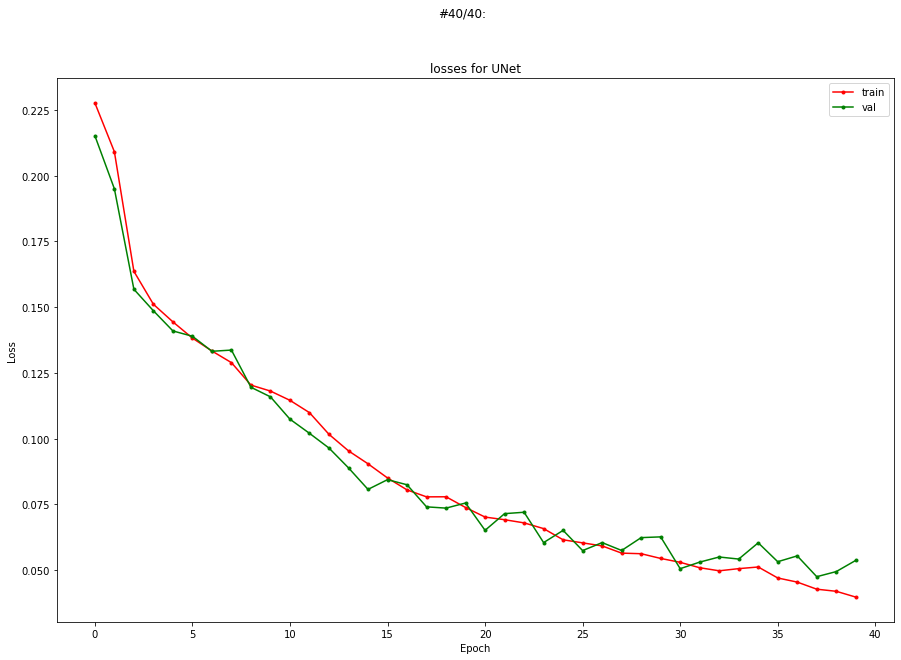

In [21]:
#!g1.1
loss_fn = DiceLoss()
net = UNet()
model_UNet, optimizer_UNet = create_model_and_optimizer(net)

model_UNet, optimizer_UNet, losses_UNet = learning_loop(
    model=model_UNet,
    optimizer=optimizer_UNet,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=loss_fn,
    name_model='UNet',
    epochs=40
)


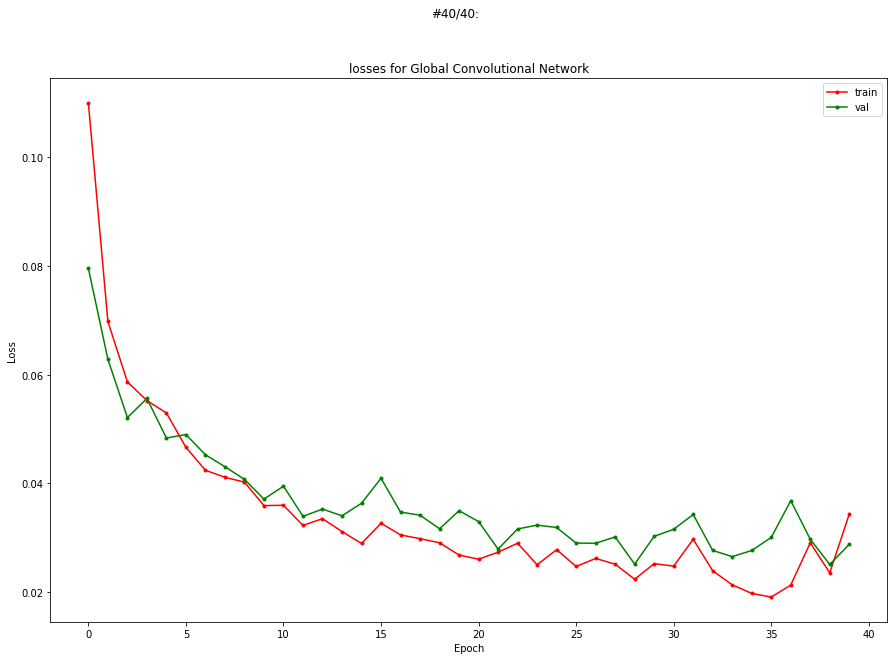

In [22]:
#!g1.1
loss_fn = DiceLoss()
net = GCN()
model_GCN, optimizer_GCN = create_model_and_optimizer(net)

model_GCN, optimizer_GCN, losses_GCN = learning_loop(
    model=model_GCN,
    optimizer=optimizer_GCN,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=loss_fn,
    name_model='Global Convolutional Network',
    epochs=40
)


У UNet ошибка выходит с единицы, так как мы обучаем модель сначала, в то время у  GCN за счет предобученых слоев ResNet ошибка начинает с лучшего результата. 
Обе модели сходятся практически к нулю, посмотрим конкретные значения в последние эпохи.

Попробуем использовать простую аугментацию: нормализация и повороты изображения по горизонтали. Возможно, из-за нашей предыдущей аугментации модель выучивала нереальные случаи и на валидации показывала результат хуже. Проверим эту гипотезу.

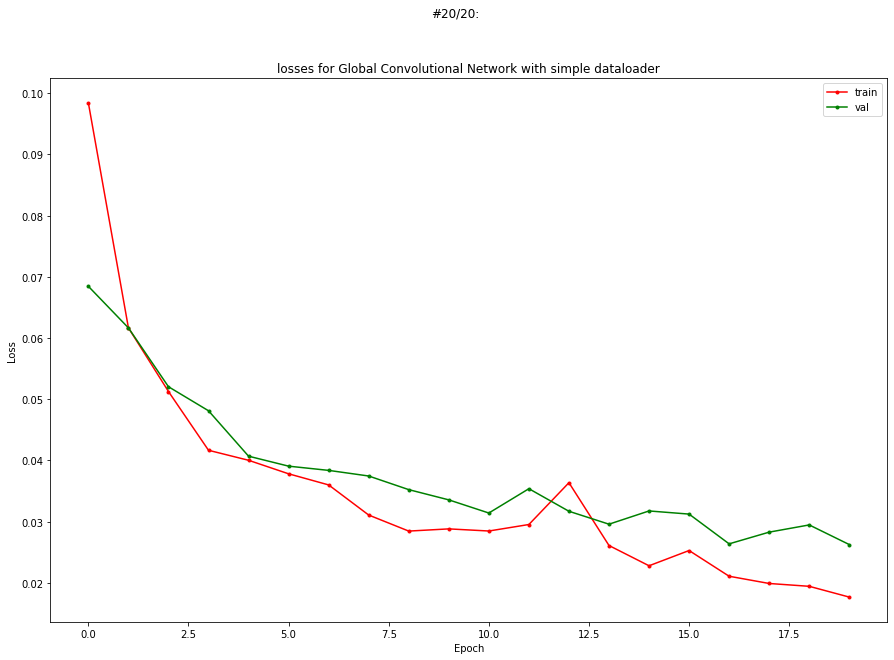

In [23]:
#!g1.1
loss_fn = DiceLoss()
net = GCN()
model_simple_GCN, optimizer_simple_GCN = create_model_and_optimizer(net)

model_simple_GCN, optimizer_simple_GCN, losses_simple_GCN = learning_loop(
    model=model_simple_GCN,
    optimizer=optimizer_simple_GCN,
    train_loader=simple_train_dataloader,
    val_loader=val_dataloader,
    criterion=loss_fn,
    name_model='Global Convolutional Network with simple dataloader',
    epochs=20
)


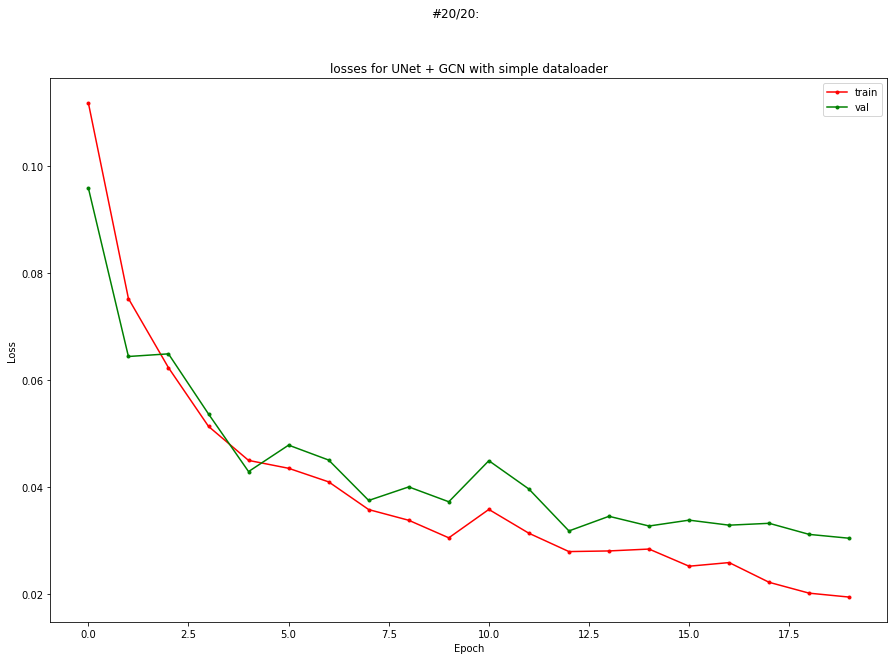

In [24]:
#!g1.1
loss_fn = DiceLoss()
net = UNet_GCN()
model_simple_UNet_GCN, optimizer_simple_UNet_GCN = create_model_and_optimizer(net)

model_simple_UNet_GCN, optimizer_simple_UNet_GCN, losses_simple_UNet_GCN = learning_loop(
    model=model_simple_UNet_GCN,
    optimizer=optimizer_simple_UNet_GCN,
    train_loader=simple_train_dataloader,
    val_loader=val_dataloader,
    criterion=loss_fn,
    name_model='UNet + GCN with simple dataloader',
    epochs=20
)


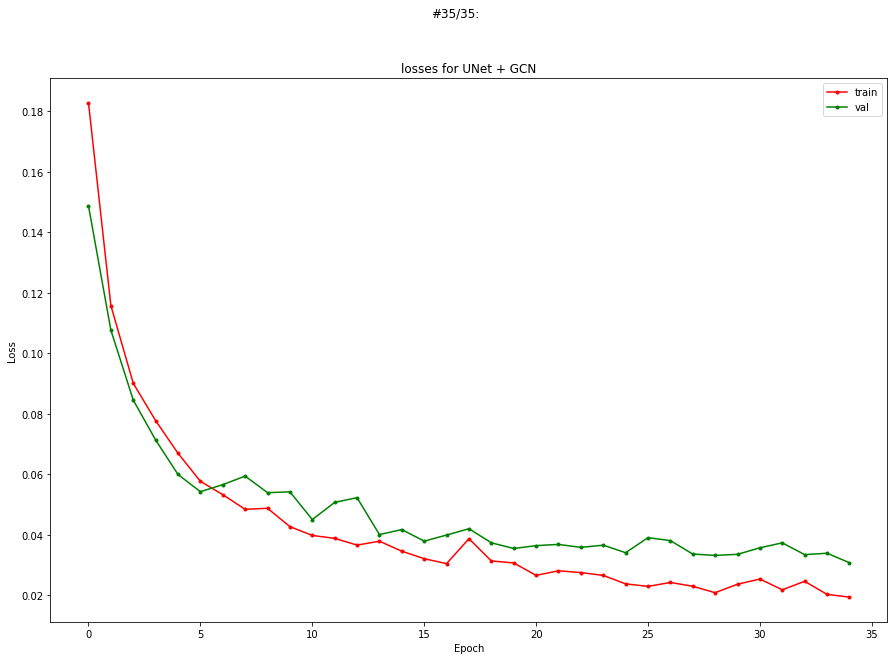

In [25]:
#!g1.1
loss_fn = DiceLoss()
net = UNet_GCN()
model_UNet_GCN, optimizer_UNet_GCN = create_model_and_optimizer(net)

model_UNet_GCN, optimizer_UNet_GCN, losses_UNet_GCN = learning_loop(
    model=model_UNet_GCN,
    optimizer=optimizer_UNet_GCN,
    train_loader=simple_train_dataloader,
    val_loader=val_dataloader,
    criterion=loss_fn,
    name_model='UNet + GCN',
    epochs=35
)


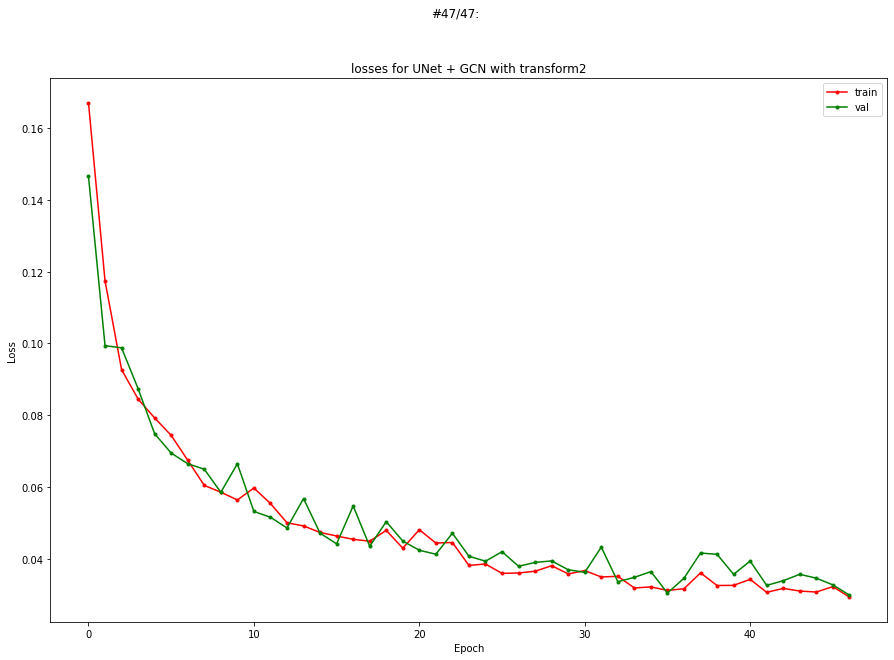

In [26]:
#!g1.1
loss_fn = DiceLoss()
net = UNet_GCN()
model_UNet_GCN2, optimizer_UNet_GCN2 = create_model_and_optimizer(net)

model_UNet_GCN2, optimizer_UNet_GCN2, losses_UNet_GCN2 = learning_loop(
    model=model_UNet_GCN2,
    optimizer=optimizer_UNet_GCN2,
    train_loader=train2_dataloader,
    val_loader=val_dataloader,
    criterion=loss_fn,
    name_model='UNet + GCN with transform2',
    epochs=47
)


In [27]:
#!g1.1
print('Validation losses for UNet from 21 to 25 epochs ', losses_UNet['val_loss'][37:])
print('Validation losses for GCN from 21 to 25 epochs ', losses_GCN['val_loss'][37:])
print('Validation losses for GCN with simple dataloader from 21 to 25 epochs ', losses_simple_GCN['val_loss'][17:])
print('Validation losses for UNet + GCN from 21 to 25 epochs ', losses_UNet_GCN['val_loss'][37:])
print('Validation losses for UNet + GCN with simple dataloader from 21 to 25 epochs ',
      losses_simple_GCN['val_loss'][17:])
print('Validation losses for UNet + GCN  with dataloader2 from 21 to 25 epochs ', losses_UNet_GCN2['val_loss'][44:])


Validation losses for UNet from 21 to 25 epochs  [0.0475400872528553, 0.049487797915935515, 0.05374481715261936]
Validation losses for GCN from 21 to 25 epochs  [0.02966139055788517, 0.025009358674287795, 0.02873177230358124]
Validation losses for GCN with simple dataloader from 21 to 25 epochs  [0.02829926796257496, 0.029476750269532205, 0.026270014792680742]
Validation losses for UNet + GCN from 21 to 25 epochs  []
Validation losses for UNet + GCN with simple dataloader from 21 to 25 epochs  [0.02829926796257496, 0.029476750269532205, 0.026270014792680742]
Validation losses for UNet + GCN  with dataloader2 from 21 to 25 epochs  [0.0345526184886694, 0.032678944244980815, 0.02983080446720123]


Модели с участием GCN показали себя лучше всего. Оценка на валидации для самой простой аугментации самая шумная, для самого сложно наоборот, оценка на валидации с меньшим шумом и больше приближена к ошибке во время тренировки, но и ошибка выше. \
Простой UNet показал себя хуже всего, думаю в первую очередь это связанно с небольшим количеством обучаемых весов по сравнению с другими моделями.

---

### Постобработка

Визуализируем результаты и посмотрим на отличия в предсказаниях моделей.

In [28]:
#!g1.1
def display_image_grid(predicted_masks, path="./data/valid", samples=5):
    """The function introduces images with real masks and predicted"""
    cols = 3
    images = os.listdir(path)
    figure, ax = plt.subplots(nrows=samples, ncols=cols, figsize=(10, 12))

    for idx in range(samples):
        ind = images[idx].split(".")[0]
        image = np.array(Image.open(f"{path}/{ind}.jpg"))
        mask = np.array(Image.open(f"{path}_mask/{ind}.png"))
        predicted_mask = predicted_masks[idx]

        ax[idx, 0].imshow(image)
        ax[idx, 1].imshow(mask, interpolation="nearest")
        ax[idx, 2].imshow(predicted_mask, interpolation="nearest")

        ax[idx, 0].set_title("Image")
        ax[idx, 1].set_title("Truth mask")
        ax[idx, 2].set_title("Predicted mask")

        ax[idx, 0].set_axis_off()
        ax[idx, 1].set_axis_off()
        ax[idx, 2].set_axis_off()

    plt.tight_layout()
    plt.show()


In [29]:
#!g1.1
def predict(model, test_loader, separate=0.6, device=device):
    """The function outputs predicted masks for the model and dataset"""
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device, non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= separate).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()

            for predicted_mask in predicted_masks:
                predictions.append(predicted_mask)
    return predictions


#### UNet

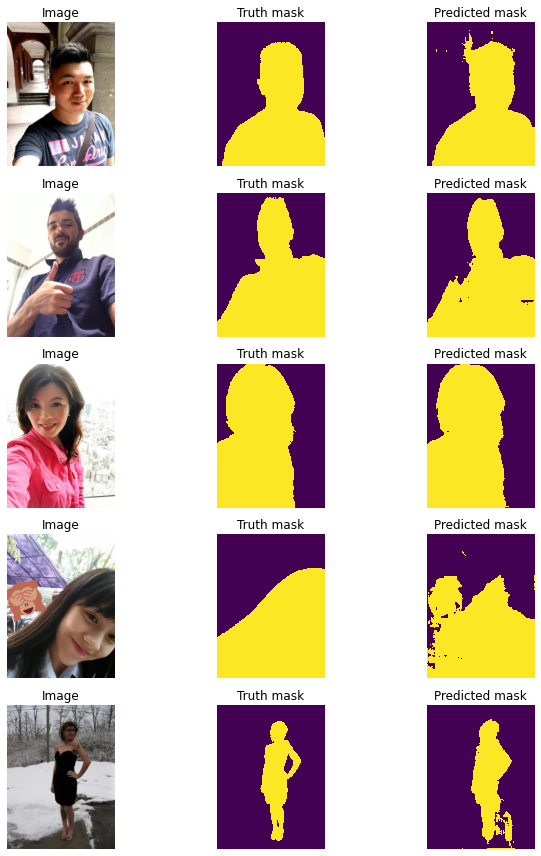

In [30]:
#!g1.1
predictions_UNet = predict(model_UNet, val_dataloader)
display_image_grid(predictions_UNet)


#### GCN

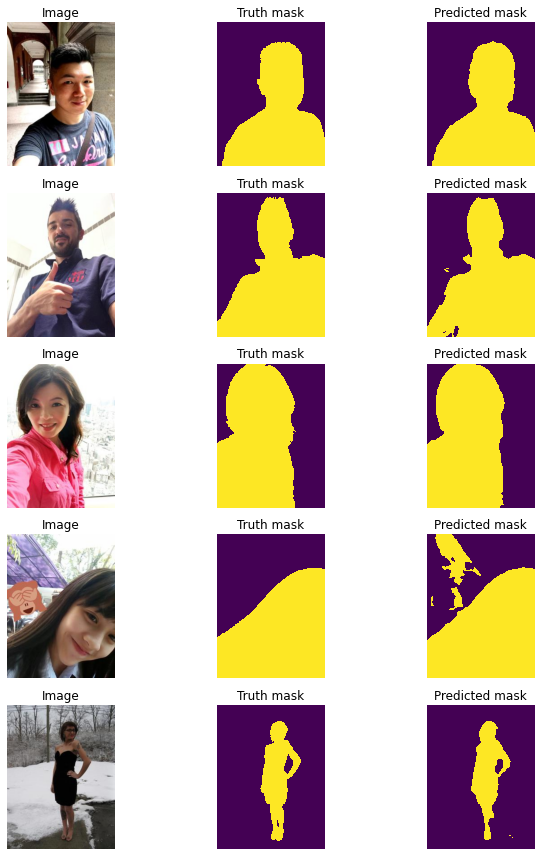

In [31]:
#!g1.1
predictions_GCN = predict(model_GCN, val_dataloader)
display_image_grid(predictions_GCN)


#### GCN с простой аугментацией

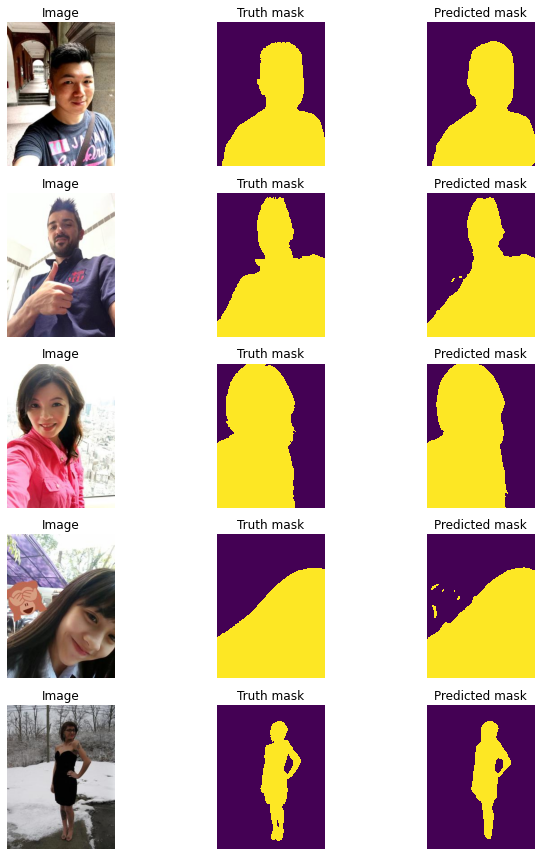

In [32]:
#!g1.1
predictions_simple_GCN = predict(model_simple_GCN, val_dataloader)
display_image_grid(predictions_simple_GCN)


#### UNet + GCN

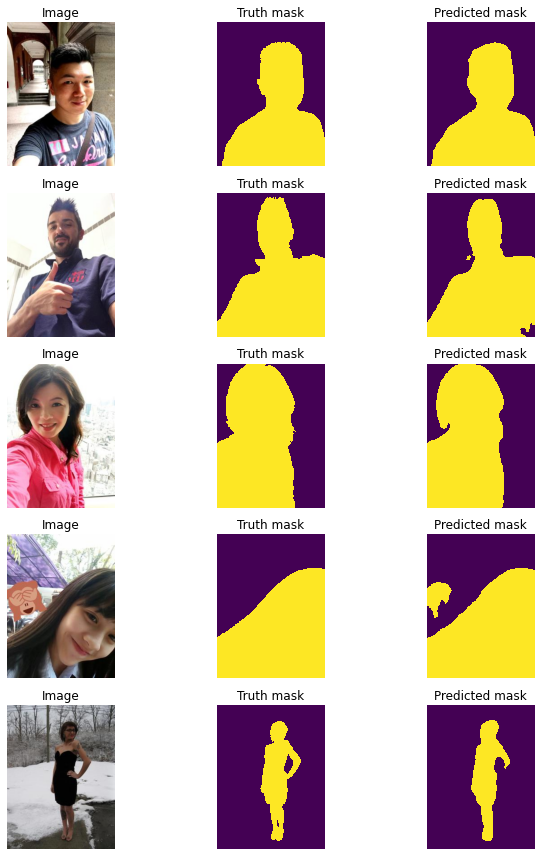

In [33]:
#!g1.1
predictions_UNet_GCN = predict(model_UNet_GCN, val_dataloader)
display_image_grid(predictions_UNet_GCN)


#### UNet + GCN с простой аугментацией

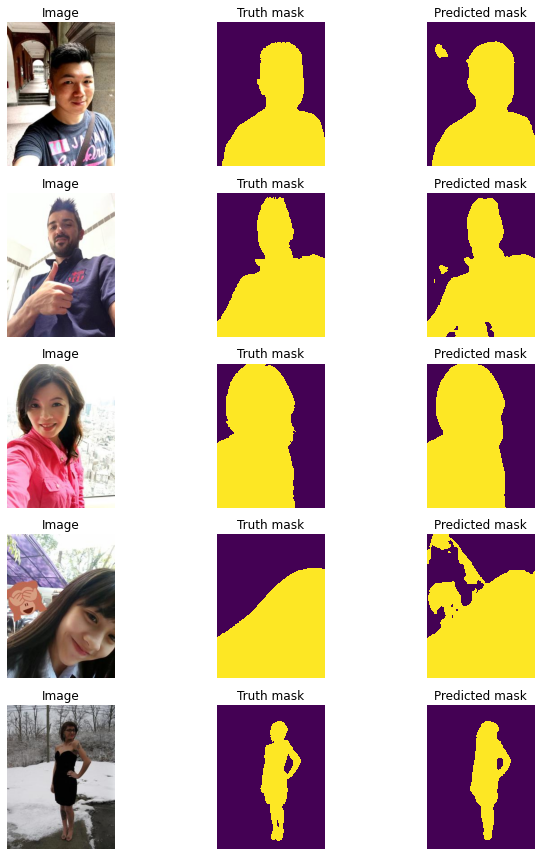

In [34]:
#!g1.1
predictions_simple_UNet_GCN = predict(model_simple_UNet_GCN, val_dataloader)
display_image_grid(predictions_simple_UNet_GCN)


#### UNet + GCN с сложной аугментацией

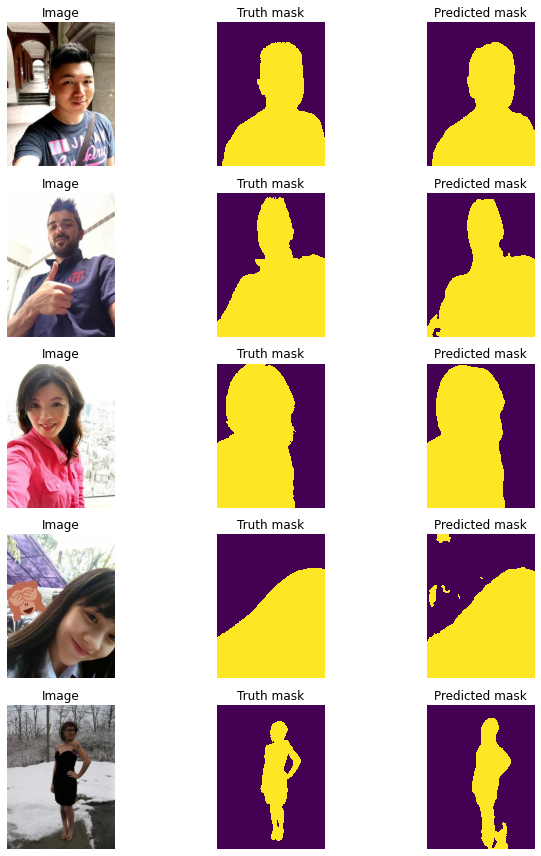

In [35]:
#!g1.1
predictions_UNet_GCN2 = predict(model_UNet_GCN2, val_dataloader)
display_image_grid(predictions_UNet_GCN2)


Некоторые модели выдают шумное предсказание, давайте попробуем подобрать оптимальный разделитель для вероятность принадлежности к человеку для всех моделей и посчитать метрику. 

In [36]:
#!g1.1
def get_best_separator(model, data_loader):
    """The function finds a separator for the background and a class that maximizes the value of Dice Metric"""
    best_separate = 0.5
    best_dci = 0

    for p in tqdm(np.linspace(0.5, 0.8, num=100)):
        cur_dci = 0

        with torch.no_grad():
            cnt_img = 0
            for images, targets in data_loader:
                images = images.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                output = model(images)

                probabilities = torch.sigmoid(output.squeeze(1))
                predicted_masks = (probabilities >= p).float() * 1

                for idx, predicted_mask in enumerate(predicted_masks):
                    cnt_img += 1
                    cur_dci += DiceMetric(predicted_mask, targets[idx])

        cur_dci /= cnt_img
        if cur_dci > best_dci:
            best_dci = cur_dci
            best_separate = p

    return best_separate, best_dci


In [37]:
#!g1.1 
separate_UNet, dci_UNett = get_best_separator(model_UNet, val_dataloader)

separate_GCN, dci_GCN = get_best_separator(model_GCN, val_dataloader)
separate_simple_GCN, dci_simple_GCN = get_best_separator(model_simple_GCN, val_dataloader)

separate_UNet_GCN, dci_UNet_GCN = get_best_separator(model_UNet_GCN, val_dataloader)
separate_simple_UNet_GCN, dci_simple_UNet_GCN = get_best_separator(model_simple_UNet_GCN, val_dataloader)
separate_UNet_GCN2, dci_UNet_GCN2 = get_best_separator(model_UNet_GCN2, val_dataloader)


Посмотрим на результаты:

In [38]:
#!g1.1
print('DCI for UNet:', dci_UNett.cpu().numpy())
print('DCI for GCN:', dci_GCN.cpu().numpy())
print('DCI for GCN + simple_transform:', dci_simple_GCN.cpu().numpy())
print('DCI for UNet + GCN:', dci_UNet_GCN.cpu().numpy())
print('DCI for GCN + UNet + simple_transform:', dci_simple_UNet_GCN.cpu().numpy())
print('DCI for UNet + GCN + transofm2:', dci_UNet_GCN2.cpu().numpy())


DCI for UNet: 0.50263715
DCI for GCN: 0.5178619
DCI for GCN + simple_transform: 0.5220528
DCI for UNet + GCN: 0.51885647
DCI for GCN + UNet + simple_transform: 0.5215434
DCI for UNet + GCN + transofm2: 0.5168679


In [39]:
#!g1.1
print('separate for UNet', separate_UNet)
print('separate for GCN', separate_GCN)
print('separate for GCN + simple_transform', separate_simple_GCN)
print('separate for UNet + GCN', separate_UNet_GCN)
print('separate for GCN + UNet + simple_transform:', separate_simple_UNet_GCN)
print('separate for UNet + GCN + transofm2', separate_UNet_GCN2)


separate for UNet 0.7242424242424242
separate for GCN 0.6878787878787879
separate for GCN + simple_transform 0.6363636363636364
separate for UNet + GCN 0.6363636363636364
separate for GCN + UNet + simple_transform: 0.7212121212121212
separate for UNet + GCN + transofm2 0.6757575757575758


Важно что модели в целом с участием GCN показали себя лучше чем UNet, а также добавления UNet к GCN не дало сильного прироста. \ 
В дальнейшем предлагаю рассматривать GCN с простой аугментацией, так метрика на немного, но всё же больше. 

Посмотрим на результат:

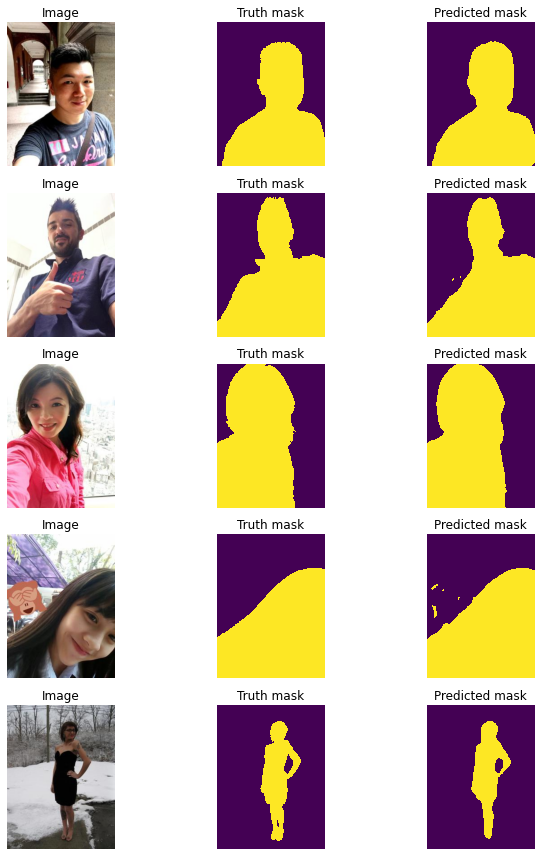

In [40]:
#!g1.1
predictions_simple_GCN = predict(model_simple_GCN, val_dataloader, separate_simple_GCN)
display_image_grid(predictions_simple_GCN)


---

### Результаты

Осталось подготовить результат:
1) сохраненные маски для картинок из valid в формате pred_valid_template.csv (в архиве с data); \
2) html страницу с предсказанием модели для всех картинок из test и папку с используемыми картинками в этой html странице для её просмотра.

In [41]:
#!g1.1
dataset_pred = pd.DataFrame(columns=['id', 'rle_mask'])


In [42]:
#!g1.1
def get_pred_masks_dataset(path, model, data, separate_GCN):
    """Function output predicted masks for the model and dataset"""
    idx_array = []
    rle_masks = []
    for idx, name_image in tqdm(enumerate(os.listdir(path))):
        idx_image = int(name_image.split('.')[0])

        image, target = data[idx]
        image = image.unsqueeze(0)

        image = image.to(device, non_blocking=True)

        output = model(image)

        probabilities = torch.sigmoid(output.squeeze(1))
        predicted_mask = (probabilities >= separate_GCN).float() * 1

        predicted_mask = predicted_mask[0].detach().cpu().numpy()

        idx_array.append(idx_image)
        rle_masks.append(encode_rle(predicted_mask))

    return idx_array, rle_masks


In [43]:
#!g1.1
idx_array, rle_masks = get_pred_masks_dataset(IMAGE_VAL_PATH, model_simple_GCN, val_data, separate_simple_GCN)


In [44]:
#!g1.1
dataset_pred['id'] = idx_array
dataset_pred['rle_mask'] = rle_masks


In [45]:
#!g1.1
dataset_pred.head()


,id,rle_mask
0,1415,10462 4 10470 4 10698 22 10937 25 11176 29 114...
1,1443,2538 5 2755 6 2776 10 2994 10 3014 14 3233 37 ...
2,1450,67 43 305 51 543 57 781 62 1020 65 1259 68 149...
3,1360,18204 17 18438 30 18672 39 18908 46 19145 51 1...
4,1404,8536 7 8774 13 9013 16 9252 19 9490 22 9729 24...


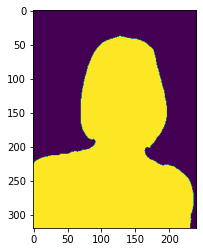

In [46]:
#!g1.1
plt.imshow(decode_rle(dataset_pred['rle_mask'][50]))
plt.show()


Всё успешно записалось, осталось сохранить датасет.

In [47]:
#!g1.1
dataset_pred.to_csv('pred_valid_template.csv')


Теперь создадим html страницу с предсказанием модели для всех картинок из test и папку с используемыми картинками в этой html странице для её просмотра. 

In [48]:
#!g1.1
predicted_masks = []
for idx, name_image in tqdm(enumerate(os.listdir(IMAGE_TEST_PATH))):
    image, idx_image = test_data[idx]
    image = image.unsqueeze(0)

    image = image.to(device, non_blocking=True)

    output = model_simple_GCN(image)

    probabilities = torch.sigmoid(output.squeeze(1))
    predicted_mask = (probabilities >= separate_simple_GCN).float() * 255

    predicted_mask = predicted_mask[0].cpu().numpy()

    predicted_masks.append(predicted_mask.astype('uint8'))


In [49]:
#!g1.1
paths_to_imgs = sorted(glob("data/test/*"))

_ = get_html(paths_to_imgs, predicted_masks, path_to_save="results/example")


In [ ]:
#!g1.1
